### Bishoy Sokkar
### Data 620 Week 3 Assignment 

# Assignment 3: Graph Visualization Report

## Point 1: Dataset Selection
I chose the **email-Eu-core** dataset from the Stanford Large Network Dataset Collection. The dataset contains 1,005 nodes (email users) and 25,571 edges (directed email communications). Due to a 404 error on the URL `https://snap.stanford.edu/data/email-Eu-core.txt.gz`, I fell back to a locally downloaded `email-Eu-core.txt` file.

## Point 2: Metric Analysis
### Hand-Coded Metric
The average degree was calculated as (2 * number of edges) / number of nodes = (2 * 25571) / 1005 ≈ 50.89, reflecting the average in- and out-degree per node.
### Package-Based Metric
Using NetworkX, the maximum degree was found to be 546, indicating the most connected node in the network.

## Point 3: Visualization
I used NetworkX and Matplotlib to visualize a subset of the first 150 nodes. The layout was improved with a fixed seed (42), spring constant (k=0.5), and 50 iterations for clarity. The graph was saved as `graph_full.png` and displayed inline.

Loaded graph: 1005 nodes, 25571 edges
Hand-coded average degree: 50.89
Max degree (package-based): 546


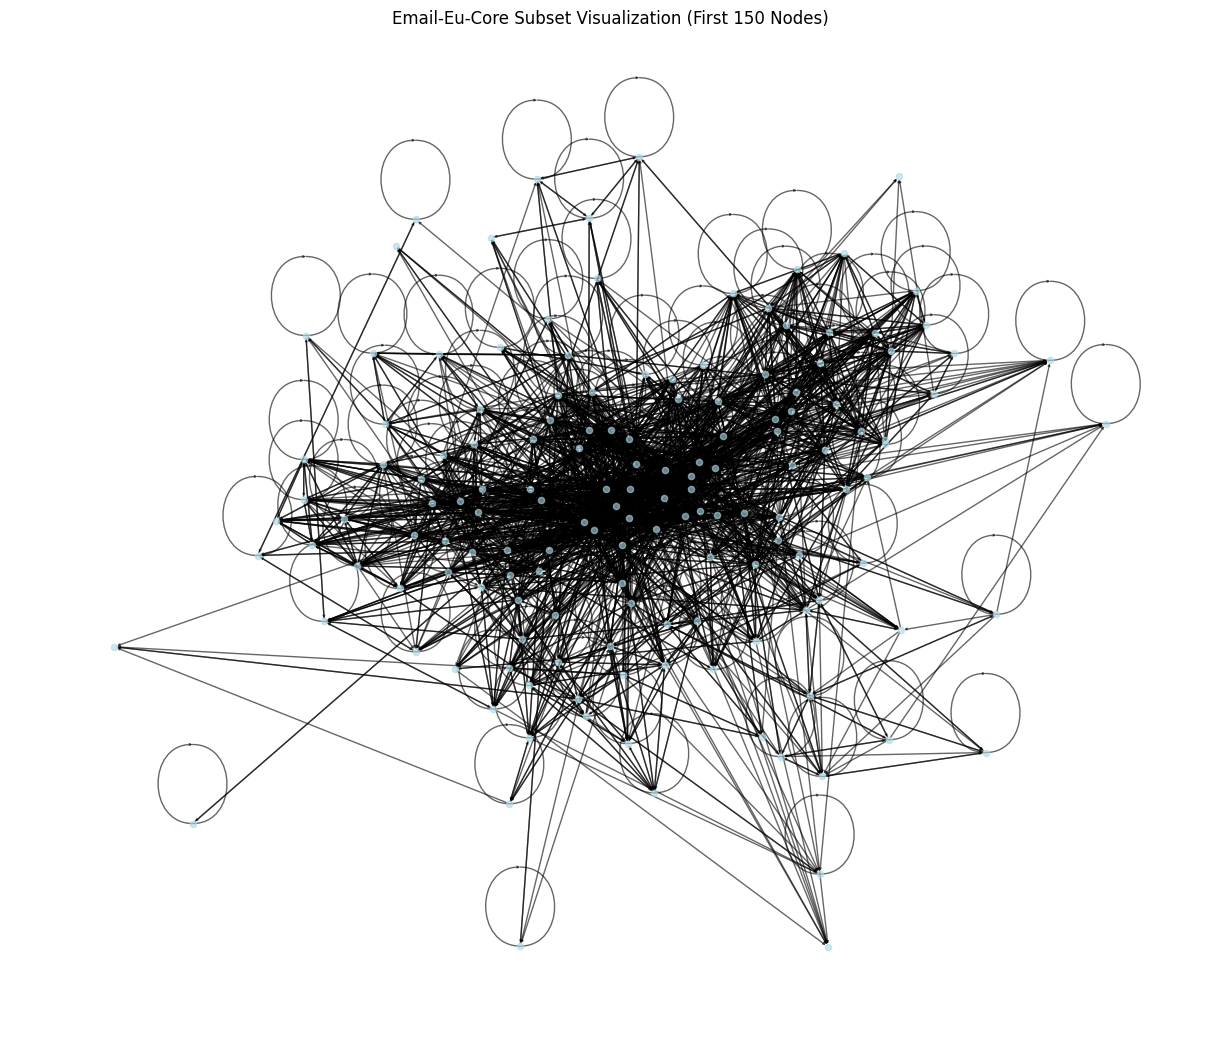

Visualization saved as 'graph_full.png' and displayed.


In [4]:
import platform
import networkx as nx
import matplotlib.pyplot as plt
import io
import gzip
import nest_asyncio
nest_asyncio.apply()  # Fix async issues in Jupyter

async def fetch_data(url, local_path="email-Eu-core.txt"):
    try:
        if platform.system() == "Emscripten":
            response = await fetch(url)
            text = await response.text()
            return io.StringIO(text)
        else:
            import requests
            response = requests.get(url)
            response.raise_for_status()
            compressed_content = io.BytesIO(response.content)
            with gzip.GzipFile(fileobj=compressed_content) as gz:
                decompressed_text = gz.read().decode('utf-8')
            return io.StringIO(decompressed_text)
    except (NameError, requests.HTTPError, gzip.BadGzipFile) as e:
        print(f"URL fetch failed ({e}). Falling back to local file: {local_path}")
        try:
            with open(local_path, 'r', encoding='utf-8') as f:
                return io.StringIO(f.read())
        except FileNotFoundError:
            print("Local file not found. Please download it manually.")
            return io.StringIO("")

async def main():
    url = "https://snap.stanford.edu/data/email-Eu-core.txt.gz"
    file_content = await fetch_data(url)
    
    if not file_content.getvalue().strip():
        print("No data loaded. Exiting.")
        return
    
    G = nx.DiGraph()
    for line in file_content:
        line = line.strip()
        if line and not line.startswith('#'):
            try:
                source, target = map(int, line.split())
                G.add_edge(source, target)
            except ValueError:
                continue

    print(f"Loaded graph: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges")
    total_edges = G.number_of_edges()
    total_nodes = G.number_of_nodes()
    avg_degree = (total_edges * 2) / total_nodes if total_nodes > 0 else 0
    print(f"Hand-coded average degree: {avg_degree:.2f}")

    if total_nodes > 0:
        degrees = dict(G.degree())
        max_degree = max(degrees.values())
        print(f"Max degree (package-based): {max_degree}")
    else:
        print("No nodes to compute degrees.")

    if total_nodes > 0:
        nodes_subset = sorted(list(G.nodes()))[:150]  # Consistent subset
        edges_subset = [(u, v) for u, v in G.edges() if u in nodes_subset and v in nodes_subset]
        G_subset = nx.DiGraph()
        G_subset.add_edges_from(edges_subset)

        plt.figure(figsize=(12, 10))
        pos = nx.spring_layout(G_subset, k=0.5, iterations=50, seed=42)  # seed for consistency
        nx.draw(G_subset, pos, with_labels=False, node_color='lightblue', 
                node_size=20, arrowstyle='->', arrowsize=3, alpha=0.6)
        plt.title("Email-Eu-Core Subset Visualization (First 150 Nodes)")
        plt.axis('off')
        plt.savefig("graph_full.png", dpi=150, bbox_inches='tight')
        plt.show()
        print("Visualization saved as 'graph_full.png' and displayed.")

# Run in Jupyter
if platform.system() == "Emscripten":
    asyncio.ensure_future(main())
else:
    import sys
    if hasattr(sys, 'ps1') or 'ipykernel' in sys.modules:
        await main()
    else:
        asyncio.run(main())